In [14]:
from statsmodels.tsa.stattools import coint
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#load paths/credentials
load_dotenv()

def load_data(file_path):
  """Load stock data from parquet or CSV file."""
  if file_path.endswith('.parquet'):
    return pd.read_parquet(file_path,engine='fastparquet')
  elif file_path.endswith('.csv'):
    return pd.read_csv(file_path)


def get_close_cols(df):
  """Extract Date and all Close price columns from DataFrame."""
  close_cols = [col for col in df.columns if 'Close' in col]
  df_close = df[['Date'] + close_cols ]
  return df_close
  
def engle_granger_test(series1, series2, significance=0.05, alpha=0.05):
  """
  Perform Engle-Granger cointegration test on two price series.
  
  Regression: log(series1) = alpha + beta * log(series2) + error
  The residuals are tested for stationarity using ADF test by caller.
  
  Args:
      series1 (pd.Series): First price series
      series2 (pd.Series): Second price series
      significance (float): Unused, kept for compatibility
      alpha (float): Unused, kept for compatibility
  
  Returns:
      OLS regression results with residuals for ADF testing
  """
  # Log transform FIRST, then add constant
  log_series1 = np.log(series1)
  log_series2 = np.log(series2)
  
  # Add constant to LOG prices
  X = sm.add_constant(log_series2)
  
  # Regress: log(series1) = alpha + beta * log(series2) + error
  model = sm.OLS(log_series1, X)
  results = model.fit()
  
  return results

def find_cointegrated_pairs(significance=0.05,alpha=0.05):
  """
  Find cointegrated stock pairs using Engle-Granger method.
  
  Tests all unique pairs, runs ADF test on residuals, saves results to pickle.
  Prints top 5 pairs sorted by p-value (lower = stronger cointegration).
  """
  file_path = os.getenv('stock_data_path')
  df = load_data(file_path)
  df=get_close_cols(df)
  #drop na
  Tickers = ['NVDA', 'AMD', 'MSFT', 'GOOGL', 'AAPL', 'V', 'MA', 'CRM', 'ADBE', 'INTC', 'QCOM', 'CSCO', 'ANET', 'ORCL', 'SAP', 'UBER', 'LYFT', 'META', 'SNAP']

  """Engle Granger Test"""
  copairs=[]
  for i in range(len(Tickers)):
    for j in range(i+1,len(Tickers)):
      ticker1=Tickers[i]
      ticker2=Tickers[j]  
      results = engle_granger_test(df[f"Close__{ticker1}"], df[f"Close__{ticker2}"])
      #get the residuals from the engle granger test and run the adf test
      adf_fuller_results = adfuller(results.resid)
      #if the signifiance level is less than the p_value rejefct the null hypothesis and do not use the pair
      if adf_fuller_results[1] < significance:
        copairs.append((adf_fuller_results[1],(ticker1,ticker2)))
  copairs.sort(key=lambda x: x[0])
  print("Top 5 cointegrated pairs:")
  print(f"p-value, (ticker1,ticker2)")
  for i in range(5):
    print(copairs[i][0], copairs[i][1])
  with open('cointegrated_pairs.pkl', 'wb') as f:
      pickle.dump(copairs, f)

# Test all combinations
# Return p-values and optimal pairs
find_cointegrated_pairs()

Top 5 cointegrated pairs:
p-value, (ticker1,ticker2)
3.982765594908068e-05 ('V', 'SAP')
0.00010077628258053696 ('MA', 'SAP')
0.000356970828700056 ('V', 'MA')
0.0008713811156952654 ('AAPL', 'ANET')
0.002390563194706585 ('GOOGL', 'SAP')


In [15]:
#continue analysis with pairs
def calculate_spread(price_1,price_2,hedge_ratio=None):
  """
  Calculate spread: log(price_1) - hedge_ratio * log(price_2).
  
  Returns:
      tuple: (spread, hedge_ratio)
  """
  # equation: log(price_1) - (hedge_ratio * log(price_2))
  if hedge_ratio is None:
    hedge_ratio = get_hedge_ratio(price_1,price_2)
  log_price_1 = np.log(price_1)
  log_price_2 = np.log(price_2)
  spread=log_price_1 - (hedge_ratio * log_price_2 )
  return spread,hedge_ratio

def get_hedge_ratio(price_1,price_2):
  """
  Calculate optimal hedge ratio using OLS regression on log prices.
  
  Regression: log(price_1) = alpha + beta * log(price_2) + error
  Returns beta (the hedge ratio).
  
  Args:
      price_1 (pd.Series): First price series
      price_2 (pd.Series): Second price series
  
  Returns:
      float: Hedge ratio (beta coefficient)
  """
  # hedge ratio is the slope of the linear regression of price_1 vs price_2
  # y = mx + b + e
  # where e is the error term
  #log(price_1) = beta*log(price_2) + alpha + e
  # solve for beta, use OLS (least squares)
  log_price_1 = np.log(price_1)
  log_price_2 = np.log(price_2)
  X = sm.add_constant(log_price_2)
  model = sm.OLS(log_price_1, X)
  results = model.fit()
  return results.params.iloc[1] # returns the slope of the linear regression, beta

def calculate_half_life(spread):
  """
  Calculate half-life of mean reversion using Ornstein-Uhlenbeck process.
  
  Half-life indicates how many periods it takes for the spread to revert
  halfway back to its mean. Shorter half-life = faster mean reversion.
  
  Args:
      spread (pd.Series): Spread time series
  
  Returns:
      float: Half-life in days (returns inf if no mean reversion detected)
  """
  # half life is the time it takes for the spread to return to the mean
  #Use Ornstein-Uhlenbeck process
  spread_lag = spread.shift(1).dropna()
  spread_diff = spread.diff().dropna()
  # Adjust for the dropped values
  min_size=min(len(spread_lag),len(spread_diff))
  lag_with_constant=sm.add_constant(spread_lag.iloc[-min_size:])
  beta = sm.OLS(spread_diff.iloc[-min_size:],lag_with_constant).fit().params.iloc[1]
  #half life is -1/beta * ln(2)
  #if beta is positive/0, return infinity
  #this is because the spread is not mean reverting
  if beta >= 0:
    return float('inf')
  return -np.log(2)/beta

def calculate_rolling_correlation(price_1,price_2,window=30):
  """
  Calculate rolling correlation of log returns between two price series.
  
  Args:
      price_1 (pd.Series): First price series
      price_2 (pd.Series): Second price series
      window (int): Rolling window size in days (default: 30)
  
  Returns:
      pd.Series: Rolling correlation values
  """
  # calculate the rolling correlation of price_1 and price_2
  # use log returns so that the correlation is more stable
  log_returns_1 = np.log(price_1/price_1.shift(1))
  log_returns_2 = np.log(price_2/price_2.shift(1))
  return log_returns_1.rolling(window=window).corr(log_returns_2)

def run_analysis():
  """
  Analyze all cointegrated pairs and generate comprehensive statistics and plots.
  
  Loads pairs from 'cointegrated_pairs.pkl', calculates hedge ratios, spreads,
  half-lives, and rolling correlations. Generates 4-panel plots for each pair.
  
  Returns:
      list: List of dictionaries containing pair analysis results with keys:
          'Pair', 'Hedge Ratio', 'Half Life', 'Spread Mean', 'Spread Std',
          'Rolling Correlation', 'Cointegration P-value'
  """
  file_path = os.getenv('stock_data_path')
  df = load_data(file_path)
  df=get_close_cols(df)
  #calculate statistics for pairs:
  with open('cointegrated_pairs.pkl', 'rb') as f:
    copairs = pickle.load(f)
  #=
  pair_results=[]
  
  for pair in copairs:
    ticker1,ticker2 = pair[1]
    close_col1 = f"Close__{ticker1}"  
    close_col2 = f"Close__{ticker2}"
    hedge_ratio = get_hedge_ratio(df[close_col1],df[close_col2])
    spread,hedge_ratio = calculate_spread(df[close_col1],df[close_col2],hedge_ratio)
    half_life = calculate_half_life(spread)
    rolling_correlation = calculate_rolling_correlation(df[close_col1],df[close_col2])
    pair_results.append({
      'Pair': f'{ticker1}-{ticker2}',
      'Hedge Ratio': hedge_ratio,
      'Half Life': half_life,
      'Spread Mean': spread.mean(),
      'Spread Std': spread.std(), 
      'Rolling Correlation': rolling_correlation.mean(),
      'Cointegration P-value': pair[0]
    })
  pair_results.sort(key=lambda x: x['Rolling Correlation'], reverse=True)
  summary_df = pd.DataFrame(pair_results)
  print("\nSummary Statistics:")
  print(summary_df.to_string(index=False))
  
  def plot_pair_analysis(df, pair_results):
    """
    Create a 4-panel plot for cointegration analysis of a trading pair.
    
    Args:
        df: DataFrame containing stock data with Date column
        pair_results: Dictionary containing pair analysis results
    """
    ticker1, ticker2 = pair_results['Pair'].split('-')
    close_col1 = f"Close__{ticker1}"  
    close_col2 = f"Close__{ticker2}"
    
    # Use values already calculated in pair_results
    hedge_ratio = pair_results['Hedge Ratio']
    half_life = pair_results['Half Life']
    
    # Only recalculate what's needed for plotting
    spread, _ = calculate_spread(df[close_col1], df[close_col2], hedge_ratio)
    rolling_correlation = calculate_rolling_correlation(df[close_col1], df[close_col2])
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{ticker1} vs {ticker2} Cointegration Analysis')

    # Plot 1: Price comparison
    #normalize the prices to the first day
    axes[0,0].plot(df['Date'], df[close_col1]/df[close_col1].iloc[0], label=ticker1, alpha=0.7)
    axes[0,0].plot(df['Date'], df[close_col2]/df[close_col2].iloc[0], label=ticker2, alpha=0.7)
    axes[0,0].set_title('Price Comparison')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Plot 2: Spread
    axes[0,1].plot(df['Date'], spread, color='red', alpha=0.7)
    axes[0,1].axhline(y=spread.mean(), color='black', linestyle='--', alpha=0.5)
    axes[0,1].set_title(f'Spread (Half-life: {half_life:.1f} days)')
    axes[0,1].grid(True)

    # Plot 3: Rolling correlation
    axes[1,0].plot(df['Date'], rolling_correlation, color='green', alpha=0.7)
    axes[1,0].axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
    axes[1,0].set_title('Rolling Correlation (30-day)')
    axes[1,0].grid(True)

    # Plot 4: Spread histogram
    axes[1,1].hist(spread.dropna(), bins=30, alpha=0.7, color='purple')
    axes[1,1].set_title('Spread Distribution')
    axes[1,1].grid(True)

    for ax in axes.flat:
      ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
      ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

  # Create plots for each pair
  # for pair_result in pair_results:
  #   plot_pair_analysis(df, pair_result)
  return pair_results



# Automated pair selection based on criteria
def select_good_pairs(criteria=None):
    """
    Select pairs that meet trading criteria for statistical arbitrage.
    
    Default criteria: correlation > 0.5, p-value < 0.05, spread mean < 0.1,
    spread std < 0.1, half-life between 5-30 days.
    
    Args:
        criteria (dict, optional): Custom criteria thresholds
    
    Returns:
        tuple: (good_pairs, all_pair_results) - filtered and all results
    """
    if criteria is None:
        criteria = {
            # PRIMARY CRITERIA (Cointegration Strength)
            'max_pvalue': 0.05,              # Standard 5% significance level
            
            # MEAN REVERSION CHARACTERISTICS (Most Important)
            'min_half_life': 1,              # Avoid negative/zero (non-mean-reverting)
            'max_half_life': 60,             # Relaxed from 30 (was too strict)
            
            # SPREAD PROPERTIES
            'max_spread_mean_abs': 5.0,      # Absolute value of spread mean < 5
            'min_spread_std': 0.001,         # Avoid degenerate spreads
            'max_spread_std': 1.0,           # Relaxed from 0.1 (was too strict)
            
            # CORRELATION (Pre-screening Only, Not Primary)
            'min_correlation': 0.3,          # Lowered from 0.5 (loose pre-filter)
            'max_correlation': 0.98,         # Avoid perfect correlation (redundancy)
        }
    pair_results=run_analysis()
    good_pairs = []

    if not pair_results or not isinstance(pair_results, list):
        print(f"ERROR: pair_results is {type(pair_results)}, expected list")
        return [], []
    
    for pair_result in pair_results:
        if not isinstance(pair_result, dict):
              print(f"SKIPPING: Invalid data type {type(pair_result)}")
              continue
        ticker1, ticker2 = pair_result['Pair'].split('-')
        
        # Check all criteria
        meets_criteria = (
           # Primary: Cointegration p-value
            pair_result['Cointegration P-value'] < criteria['max_pvalue'] and
            
            # Primary: Mean reversion speed
            criteria['min_half_life'] <= pair_result['Half Life'] <= criteria['max_half_life'] and
            
            # Secondary: Spread properties
            abs(pair_result['Spread Mean']) < criteria['max_spread_mean_abs'] and
            criteria['min_spread_std'] <= pair_result['Spread Std'] <= criteria['max_spread_std'] and
            
            # Tertiary: Correlation (pre-screening only)
            criteria['min_correlation'] <= pair_result['Rolling Correlation'] <= criteria['max_correlation']
        )
        
        if meets_criteria:
            good_pairs.append(pair_result)
            print(f"✓ {ticker1}-{ticker2}")
            print(f"  P-value: {pair_result['Cointegration P-value']:.6f} (< {criteria['max_pvalue']})")
            print(f"  Half-life: {pair_result['Half Life']:.1f} days ({criteria['min_half_life']}-{criteria['max_half_life']})")
            print(f"  Spread: μ={pair_result['Spread Mean']:.3f}, σ={pair_result['Spread Std']:.3f}")
            print(f"  Correlation: {pair_result['Rolling Correlation']:.3f}")
            print()
    print("\nCriteria used:")
    print(f"- Rolling correlation > {criteria['min_correlation']}")
    print(f"- Cointegration p-value < {criteria['max_pvalue']}") 
    print(f"- Spread mean is close to 0 (< {criteria['max_spread_mean_abs']})")
    print(f"- Spread std is relatively low (< {criteria['max_spread_std']})")
    print(f"- Half life is reasonable ({criteria['min_half_life']}-{criteria['max_half_life']} days)")
    
    return good_pairs, pair_results

# Run automated selection
print("Automated Pair Selection Results:")
print("=" * 50)
good_pairs,pair_results = select_good_pairs()

print(f"\nFound {len(good_pairs)} good pairs out of {len(pair_results)} total pairs")





Automated Pair Selection Results:

Summary Statistics:
      Pair  Hedge Ratio  Half Life  Spread Mean  Spread Std  Rolling Correlation  Cointegration P-value
      V-MA     0.976802  25.923124    -0.359580    0.031972             0.855501               0.000357
MSFT-GOOGL     0.999786  56.483140     0.885621    0.096483             0.636788               0.040480
 NVDA-MSFT     3.323484  35.987581   -15.471954    0.222466             0.595533               0.005986
GOOGL-META     0.399651  56.271654     2.561386    0.131173             0.582688               0.003487
 NVDA-ANET     1.392992  53.813198    -1.565464    0.229204             0.557370               0.020888
  AMD-MSFT     0.906518  48.924675    -0.524229    0.158013             0.501613               0.035001
  MSFT-SAP     0.604997  68.270507     2.734468    0.131223             0.499145               0.012153
 AMD-GOOGL     0.914951  56.518663     0.236610    0.178139             0.487540               0.049958
 MSFT-ORC


P-value Statistics:
Total pairs tested: 43
Significant pairs (p < 0.05): 86
Highly significant pairs (p < 0.01): 22
Very highly significant pairs (p < 0.001): 8

Min p-value: 0.000040
Max p-value: 0.049958
Median p-value: 0.023911


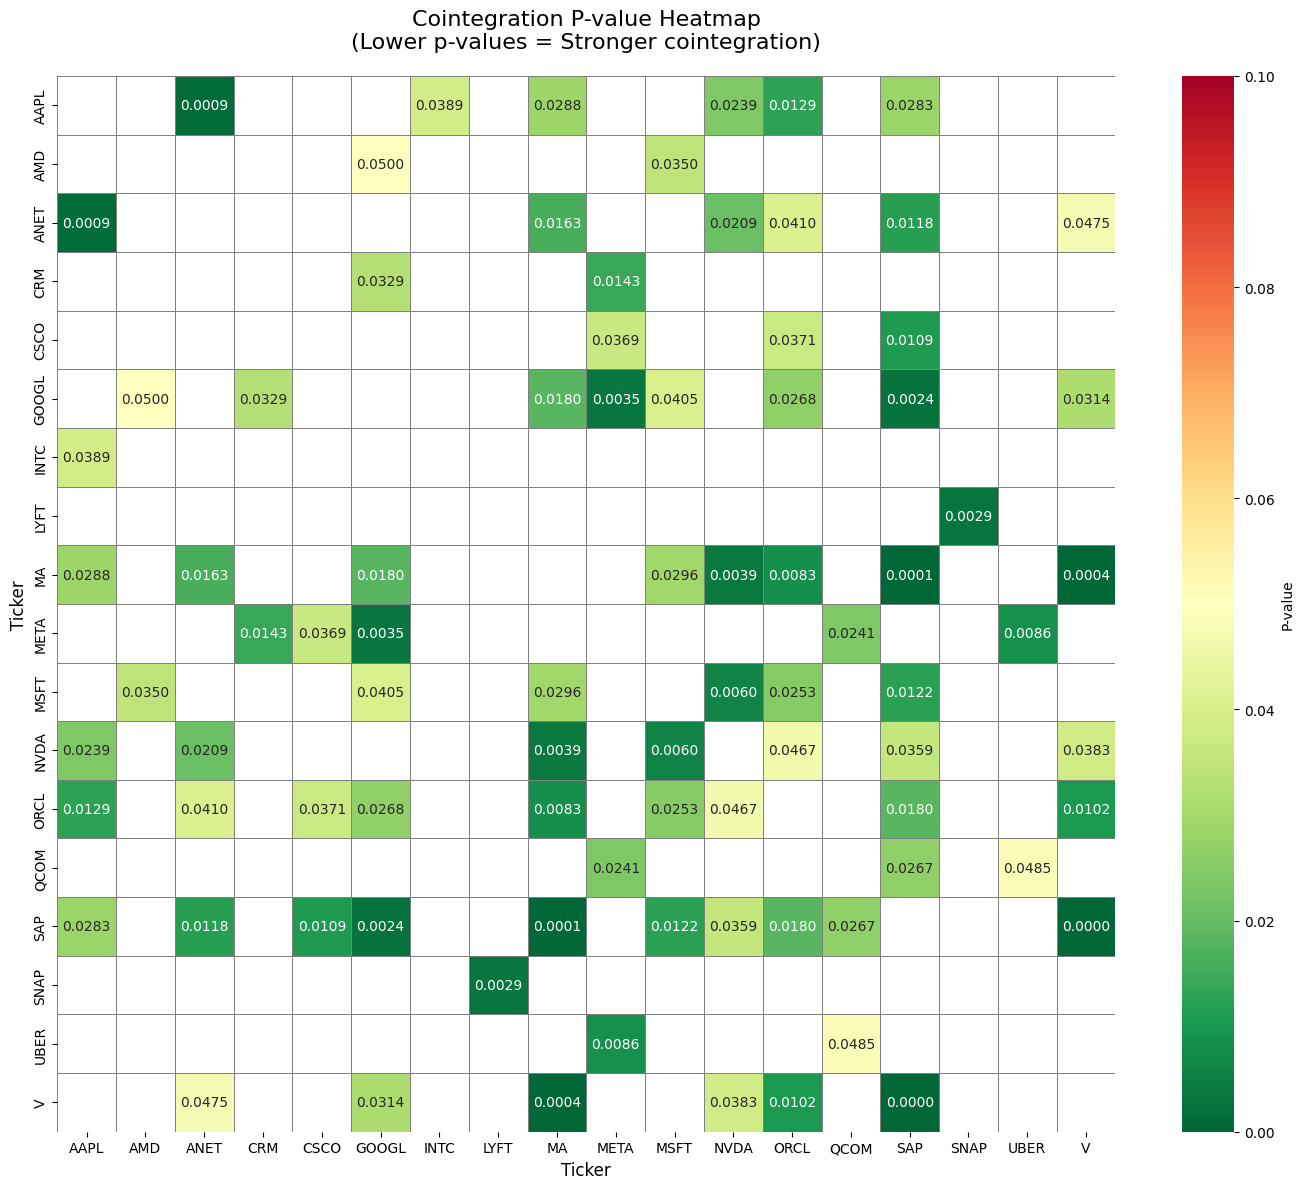

In [ ]:

def create_pvalue_heatmap():
    """
    Create a heatmap of cointegration p-values for all ticker pairs.
    
    Lower p-values (darker colors) indicate stronger cointegration.
    P-values < 0.05 are considered statistically significant.
    """
    # Load the cointegrated pairs
    with open('cointegrated_pairs.pkl', 'rb') as f:
        copairs = pickle.load(f)
    
    # Get unique tickers
    tickers = set()
    for pair in copairs:
        ticker1, ticker2 = pair[1]
        tickers.add(ticker1)
        tickers.add(ticker2)
    
    tickers = sorted(list(tickers))
    
    # Create a matrix for p-values
    n = len(tickers)
    pvalue_matrix = np.ones((n, n))  # Initialize with 1.0 (no cointegration)
    
    # Fill the matrix with p-values
    for pair in copairs:
        pvalue, (ticker1, ticker2) = pair
        idx1 = tickers.index(ticker1)
        idx2 = tickers.index(ticker2)
        # Matrix is symmetric
        pvalue_matrix[idx1, idx2] = pvalue
        pvalue_matrix[idx2, idx1] = pvalue
    
    # Set diagonal to NaN (a ticker with itself)
    np.fill_diagonal(pvalue_matrix, np.nan)
    
    # Create the heatmap
    plt.figure(figsize=(14, 12))
    
    # Use a diverging colormap where lower p-values are darker
    # Mask values that are 1.0 (pairs not tested)
    mask = pvalue_matrix == 1.0
    
    sns.heatmap(
        pvalue_matrix,
        annot=True,
        fmt='.4f',
        cmap='RdYlGn_r',  # Red (low p-value) to Green (high p-value)
        xticklabels=tickers,
        yticklabels=tickers,
        cbar_kws={'label': 'P-value'},
        vmin=0,
        vmax=0.1,  # Focus on significant range
        linewidths=0.5,
        linecolor='gray',
        mask=mask
    )
    
    plt.title('Cointegration P-value Heatmap\n(Lower p-values = Stronger cointegration)', 
              fontsize=16, pad=20)
    plt.xlabel('Ticker', fontsize=12)
    plt.ylabel('Ticker', fontsize=12)
    
    plt.tight_layout()
    
    # Print summary statistics
    valid_pvalues = pvalue_matrix[~np.isnan(pvalue_matrix) & (pvalue_matrix < 1.0)]
    print(f"\nP-value Statistics:")
    print(f"Total pairs tested: {len(copairs)}")
    print(f"Significant pairs (p < 0.05): {np.sum(valid_pvalues < 0.05)}")
    print(f"Highly significant pairs (p < 0.01): {np.sum(valid_pvalues < 0.01)}")
    print(f"Very highly significant pairs (p < 0.001): {np.sum(valid_pvalues < 0.001)}")
    print(f"\nMin p-value: {np.min(valid_pvalues):.6f}")
    print(f"Max p-value: {np.max(valid_pvalues):.6f}")
    print(f"Median p-value: {np.median(valid_pvalues):.6f}")
    
    return pvalue_matrix, tickers

# Create the heatmap
pvalue_matrix, tickers = create_pvalue_heatmap()
plt.show()